In [116]:
import os
import pandas as pd
import numpy as np

import math
import re
import jupyter_utils as ju

from matplotlib import pyplot as plt

import ast

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import metrics

ju.apply_options(pd)
ju.reload(ju)

In [51]:
def read_results():
    
    is_resultfile = lambda filename: re.search(r'^spark_.*\.csv$', filename) is not None
    files = list(filter(is_resultfile, os.listdir()))
    
    df_results = pd.DataFrame()
    for file in files:
        
        df_model = pd.read_csv(file)
        # Parse the original y test and y prediction, since I've persisted as string
        df_model['y_predictions'] = df_model.y_predictions.apply(ast.literal_eval)
        df_model['y_test'] = df_model.y_test.apply(ast.literal_eval)
        
        df_results = pd.concat([df_results, df_model])
    
    df_results = df_results.sort_values(['auc'], ascending = False)
    df_results = df_results.reset_index(drop = True)
    return df_results

df_results = read_results()
df_results.drop(['y_test', 'y_predictions'], axis = 1).head(5)

,accuracy,precision,recall,auc,f1_macro,f1_micro,f1_weighted,binary,beta,tp,fn,fp,tn,model_name,hyperparameters
0,0.857022,0.632128,0.807361,0.839025,0.807150,0.857022,0.862890,0.709078,0.764950,1031,246,600,4040,LogisticRegressionModel,"[('aggregationDepth', 2), ('elasticNetParam', 0.0), ('family', 'auto'), ('featuresCol', 'features'), ('fitIntercept', True), ('labelCol', 'idx_labels'), ('maxIter', 100), ('predictionCol', 'prediction'), ('probabilityCol', 'probability'), ('rawPredictionCol', 'rawPrediction'), ('regParam', 0.0), ('standardization', True), ('threshold', 0.5), ('tol', 0.0001), ('weightCol', 'class_weights')]"
1,0.899611,0.819457,0.685983,0.822194,0.842099,0.899611,0.896261,0.746803,0.709082,876,401,193,4447,GBTClassificationModel,"[('cacheNodeIds', False), ('checkpointInterval', 10), ('featureSubsetStrategy', 'all'), ('featuresCol', 'features'), ('labelCol', 'canceled'), ('lossType', 'logistic'), ('maxBins', 32), ('maxDepth', 6), ('maxIter', 100), ('maxMemoryInMB', 256), ('minInfoGain', 0.0), ('minInstancesPerNode', 1), ('predictionCol', 'prediction'), ('seed', 42), ('stepSize', 0.1), ('subsamplingRate', 0.8)]"
2,0.897752,0.850000,0.638998,0.803982,0.833254,0.897752,0.892196,0.729549,0.672380,816,461,144,4496,RandomForestClassificationModel,"[('cacheNodeIds', False), ('checkpointInterval', 10), ('featureSubsetStrategy', 'auto'), ('featuresCol', 'features'), ('impurity', 'gini'), ('labelCol', 'canceled'), ('maxBins', 30), ('maxDepth', 20), ('maxMemoryInMB', 256), ('minInfoGain', 0.0), ('minInstancesPerNode', 1), ('numTrees', 60), ('predictionCol', 'prediction'), ('probabilityCol', 'probability'), ('rawPredictionCol', 'rawPrediction'), ('seed', 42), ('subsamplingRate', 1.0)]"
3,0.880176,0.756318,0.656226,0.799018,0.813845,0.880176,0.877002,0.702725,0.674067,838,439,270,4370,DecisionTreeClassificationModel,"[('cacheNodeIds', False), ('checkpointInterval', 10), ('featuresCol', 'features'), ('impurity', 'gini'), ('labelCol', 'canceled'), ('maxBins', 32), ('maxDepth', 10), ('maxMemoryInMB', 256), ('minInfoGain', 0.0), ('minInstancesPerNode', 1), ('predictionCol', 'prediction'), ('probabilityCol', 'probability'), ('rawPredictionCol', 'rawPrediction'), ('seed', 42)]"


In [120]:
df_summary = df_results[['model_name', 'auc', 'binary', 'recall']]
df_summary.columns = ['Model', 'AUC', 'F1-binary', 'Recall']
df_summary = df_summary.sort_values(['Recall', 'AUC', 'F1-Binary'], ascending = F)

df_summary.head(5)

,Model,AUC,F1-binary,Recall
0,LogisticRegressionModel,0.839025,0.709078,0.807361
1,GBTClassificationModel,0.822194,0.746803,0.685983
2,RandomForestClassificationModel,0.803982,0.729549,0.638998
3,DecisionTreeClassificationModel,0.799018,0.702725,0.656226


In [112]:
colors = ['darkslategrey', 'darkorange', 'darkred', 'limegreen', 'darkviolet']

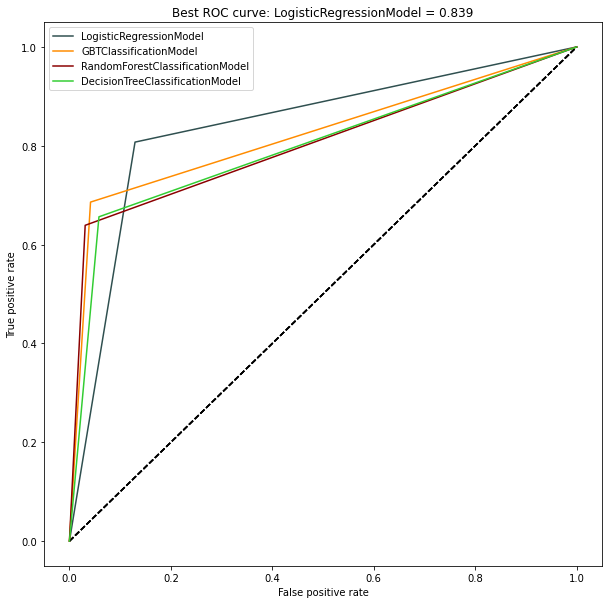

In [114]:
def plot_roc(df_results, _colors = colors):
    
    plt.figure(figsize=(10, 10))
    
    _model_results = []

    for _row in list(range(0, len(df_results))):

        y_test = df_results.y_test.values[_row]
        y_predictions = df_results.y_predictions.values[_row]

        fp, tp, _ = roc_curve(y_test, y_predictions)
        auc = roc_auc_score(y_test, y_predictions)
        
        _model_results.append({ 
            'name' : df_results.model_name[_row],
            'auc' : auc 
        })

        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fp, tp, color = _colors[_row], label = df_results.model_name[_row])

    max_auc = max(map(lambda model: model['auc'], _model_results))
    best_auc = next((x for x in _model_results if x['auc'] == max_auc), None)
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f"Best ROC curve: {best_auc['name']} = {np.around(best_auc['auc'], 3)}")
    plt.legend(loc = 'best')
    plt.show()
    
plot_roc(df_results)

<Figure size 432x288 with 0 Axes>

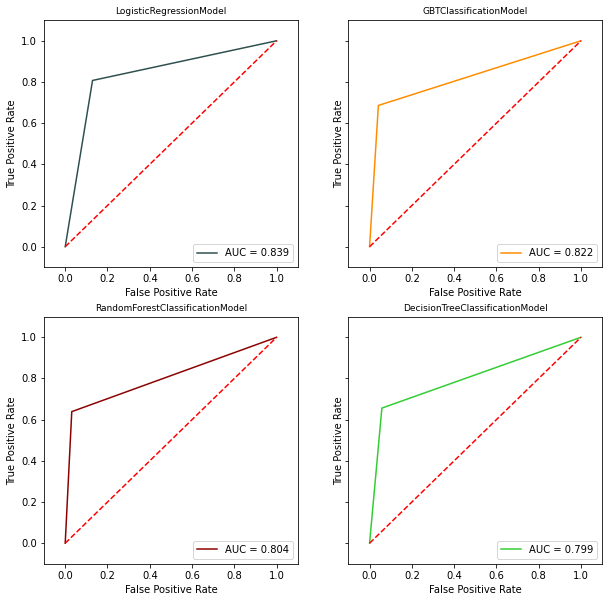

In [117]:
def plot_auc_group(df_results):

    num_cols = 2
    num_rows = math.ceil(len(df_results) / num_cols)

    plt.clf()
    fig, axes = plt.subplots(num_rows, num_cols, sharey = True)
    fig.set_size_inches(num_cols * 5, num_rows * 5)

    for i in list(range(len(df_results))):

        _color = colors[i]

        y_test = df_results.iloc[i].y_test
        y_predictions = df_results.iloc[i].y_predictions

        fpr, tpr, _ = metrics.roc_curve(y_test, y_predictions)

        auc_score = metrics.auc(fpr, tpr)

        ax = axes[i // num_cols, i % num_cols]

        ax.set_title(df_results.iloc[i].model_name, fontsize = 9)
        ax.plot(fpr, tpr, color = _color, label = 'AUC = {:.3f}'.format(auc_score))
        ax.legend(loc = 'lower right')

        ax.plot([0, 1], [0, 1],'r--')

        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')

plot_auc_group(df_results)